In [1]:
# https://www.kaggle.com/saswatsarangi99/final-commit-dcnn-fer-69
# https://www.kaggle.com/gauravsharma99/facial-emotion-recognition
# https://medium.com/@greatsharma04?p=763df7946a64
# 資料集https://www.kaggle.com/gauravsharma99/ck48-5-emotions

import numpy as np
import pandas as pd
import os

In [2]:
# 抓取檔案路徑與檔案名稱
for dirname, _,filenames in os.walk(r'./archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./archive\Submission.csv
./archive\fer2013\fer2013\fer2013.bib
./archive\fer2013\fer2013\fer2013.csv
./archive\fer2013\fer2013\README


In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

from tensorflow.keras.layers import Conv2D,Dense,AveragePooling2D,MaxPooling2D, Flatten, Dropout 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
import scikitplot
import seaborn as sns
import math
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from keras.utils import np_utils

In [4]:
data = pd.read_csv(r'./archive/fer2013/fer2013/fer2013.csv')
data.shape

(35887, 3)

In [5]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [28]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [7]:
emotion_map = {0: ' Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


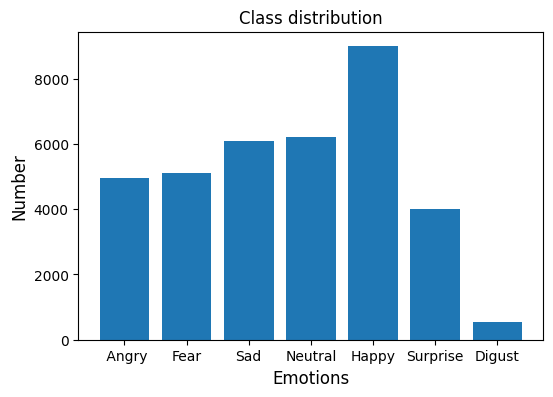

In [8]:
plt.figure(figsize=(6, 4))
plt.bar(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.show()

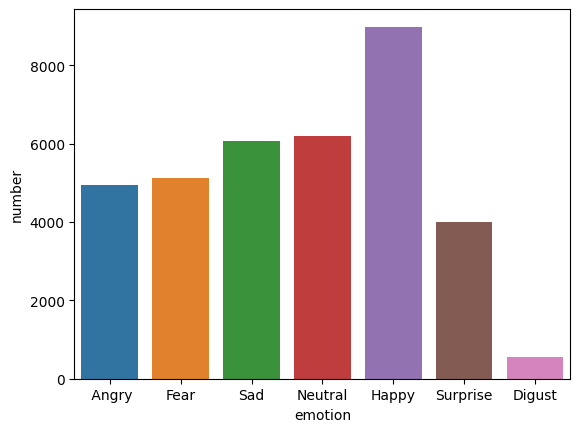

In [48]:
sns.barplot(data= emotion_counts, x='emotion', y= 'number')
plt.show()

In [66]:
math.sqrt(len(data.pixels[0].split(' ')))

48.0

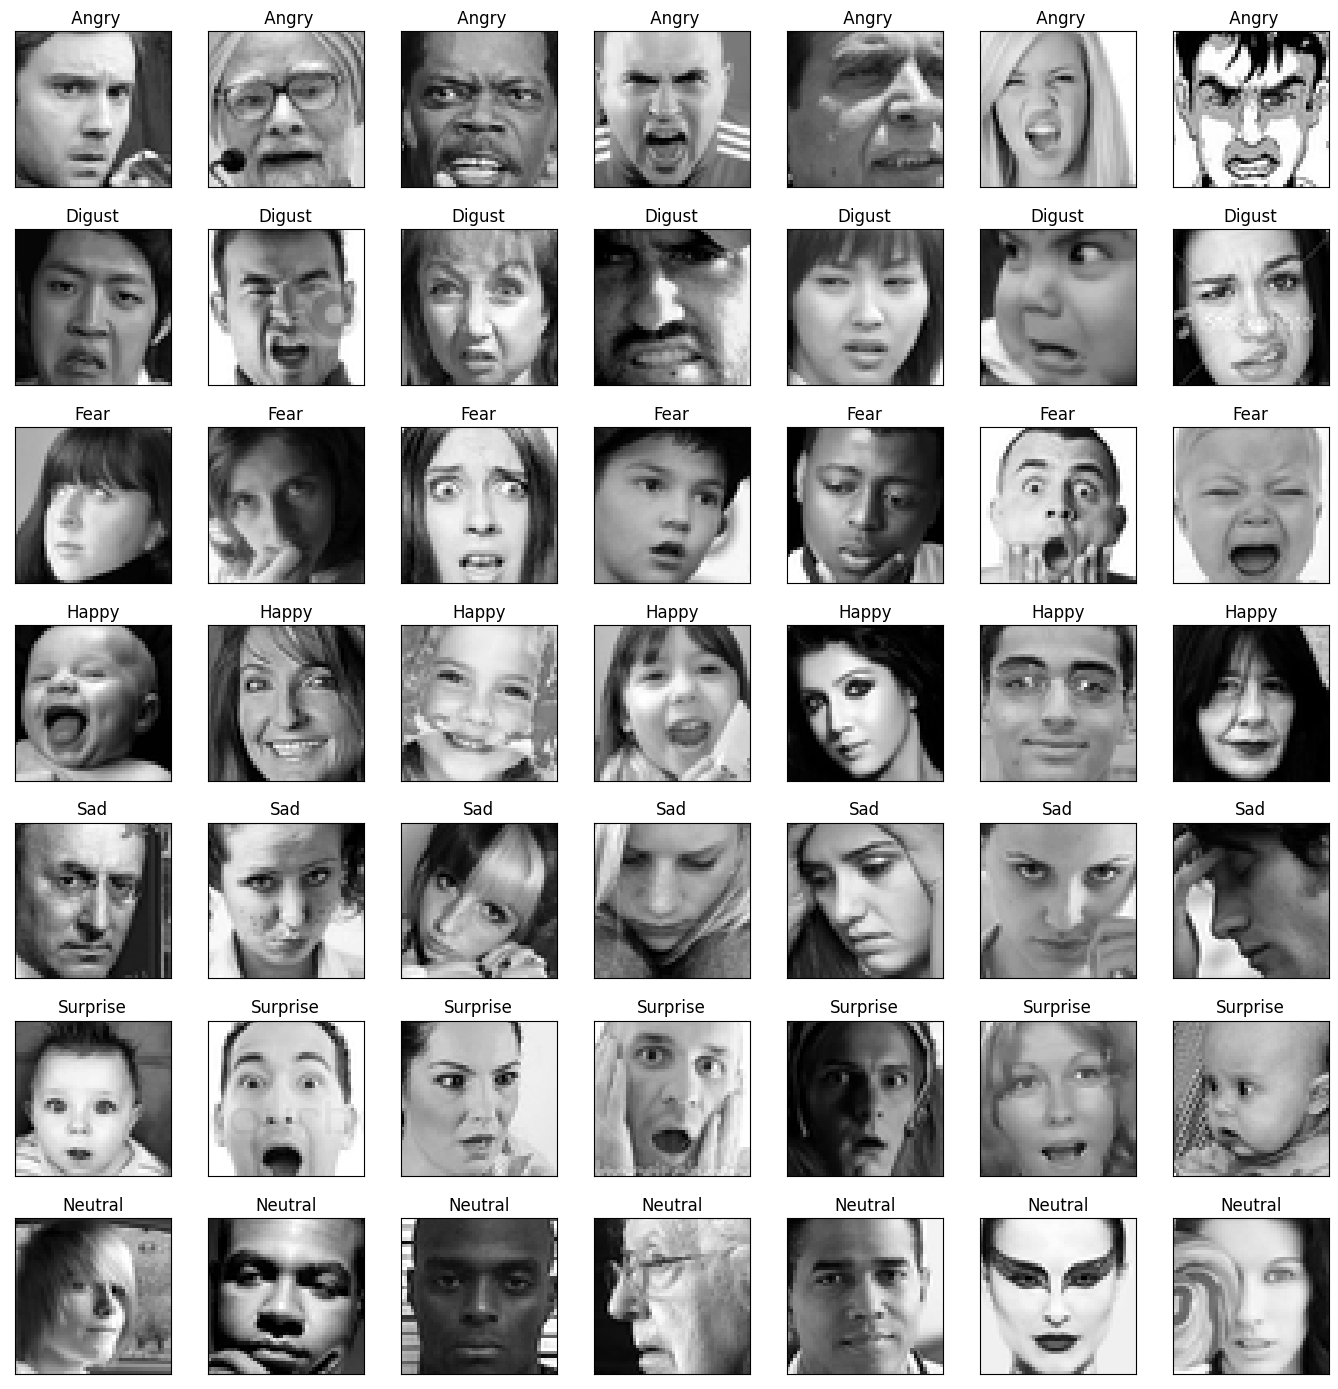

In [73]:
'''
資料橫跨多年另、多人種，且不限真人，也有卡通
這個數據中包含了從網路抓取下來的資料

'''

# 繪製圖片

fig = plt.figure(1,(14,14))
k = 0

for label in sorted(data.emotion.unique()):
#     print(label)
    for j in range(7):
#         print('j:',j)
        px = data[data.emotion == label].pixels.iloc[k]
        #轉為影像的矩陣
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
#         print(px.shape)
        
        k+=1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_map[label])
        #自動保持子圖之間的正確間距
        plt.tight_layout()

plt.show()

### 神經網路CNN

In [74]:
'''
因為目前的資料不符合做為CNN模型需要的格式，所以我們需要做些轉換，
另外先將資料進行正規化
'''

x = []
y = []
first = True
for line in open(r'./archive/fer2013/fer2013/fer2013.csv'):
    if first:
        first = False
    else:
        row = line.split(',')
        x.append([int(p) for p in row[1].split()])
        y.append(int(row[0]))
x, y = np.array(x) / 255.0, np.array(y)

In [79]:
# https://blog.csdn.net/qq_38409301/article/details/88559889
# -1的功用為row固定，column未知
x = x.reshape(-1, 48, 48, 1)
x.shape

(35887, 48, 48, 1)

In [82]:
'''
另一種寫法
將影像轉為48*48*1的大小，只有1的原因是都是灰階
再將每一個影像從第四個維度開始堆疊
'''
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape

(35887, 48, 48, 1)

In [91]:
'''
random_state 隨機種子
https://blog.csdn.net/xiaohutong1991/article/details/107923970
shuffle 打亂樣本
https://www.cnblogs.com/qqhfeng/p/5762471.html
stratify stratify是為了保持split前類的分佈，意思是拆分的資料類別的比例會與原本的相同
https://iter01.com/522027.html
'''

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32298, 48, 48, 1) (3589, 48, 48, 1) (32298,) (3589,)


In [92]:
num_class = len(set(y))
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
print(y_train.shape, y_test.shape)

(32298, 7) (3589, 7)


In [13]:
'''
shear_range
zoom_range
height_shift_range
width_shift_range
rotation_range
horizontal_flip
vertical_flip

ImageDataGenerator能幫助模型，因為對影像添加了一些可能在現實中會遇到的狀況，例如旋轉、裁切等

'''

datagen = ImageDataGenerator(
    zoom_range = 0.15,
    height_shift_range = 0.15,
    width_shift_range = 0.15,
    rotation_range = 10,
    horizontal_flip = True,
    vertical_flip = True
)

In [14]:
'''
將設定的好的參數fit到訓練集上
'''
datagen.fit(x_train)

In [15]:
'''

Sequential：為用來包網路架構
Conv2D：用於架構卷積
https://keras.io/zh/layers/convolutional/

Input_shape：當是模型第一層的時候，就需要提供這個
filters：輸出空間的維度，
kernel_size：卷積窗口的寬度與高度
activation：要使用的激活函數

ELU：Exponential Linear Unit
https://paperswithcode.com/method/elu

BatchNormalization：讓各層擁有適當的廣度，不「強制性」調整活性化的分布
優勢：增加學習率且可快速學習；不會過度依賴預設值：可以控制過度學習，減少Dropout等必要性
在進行學習時，以小批次為單位，依照各個小批次來進行正規化

MaxPooling2D：對於空間數據的最大池化，從窗格中挑選最大的值

Dropout：一邊隨機消除神經元，一邊學習的手法，藉此停止之後的訊號傳遞

flatten：把X轉換成為一維陣列，意思是將資料展平


Dense：全連接層，相當於添加一個層
'''

cnn_model = Sequential()

Input_shape = (48, 48, 1)


cnn_model.add(
    Conv2D(
        filters = 64, 
        kernel_size = (3,3), 
        activation = 'elu', 
        kernel_initializer='he_normal', 
        padding='same',
        input_shape = Input_shape
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        activation = 'elu',
        kernel_initializer='he_normal',
        padding='same'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.3))


cnn_model.add(
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        activation = 'elu',
        kernel_initializer='he_normal',
        padding='same'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        activation = 'elu',
        kernel_initializer='he_normal',
        padding='same'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.4))

cnn_model.add(
    Conv2D(
        filters = 256,
        kernel_size = (3,3),
        activation = 'elu',
        kernel_initializer='he_normal',
        padding='same'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(
    Conv2D(
        filters = 256,
        kernel_size = (3,3),
        activation = 'elu',
        kernel_initializer='he_normal',
        padding='same'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Dropout(0.5))

'''
比另一個方法多出來的，變成使用relu
'''
cnn_model.add(Flatten())

cnn_model.add(
    Dense(
        units = 1024, 
        activation = 'relu', 
        kernel_initializer='he_uniform'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

'''
不懂單位，但一直對半
'''
cnn_model.add(
    Dense(
        units = 512,
        activation = 'relu',
        kernel_initializer='he_uniform'
    )
)
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))

cnn_model.add(
    Dense(
        units = 256,
        activation = 'relu',
        kernel_initializer='he_uniform'
    )
)
cnn_model.add(BatchNormalization())

cnn_model.add(
    Dense(
        units = 7,
        activation = 'softmax'
    )
)

cnn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=0.001,beta_1=0.9,beta_2=0.999),
    metrics = ['accuracy']
)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)      

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
'''
epochs=350，在神經網路中完整的傳遞一次
batch_size，決定我們一次訓練的樣本數目
verbose，日誌顯示，0為不在標準輸出流輸出日誌信息，1為輸出進度條記錄，2為每個epoch輸出一行記錄
'''
history = cnn_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/100
505/505 [==============================] - 390s 760ms/step - loss: 1.9179 - accuracy: 0.2344 - val_loss: 1.7590 - val_accuracy: 0.2875
Epoch 2/100
505/505 [==============================] - 318s 630ms/step - loss: 1.7578 - accuracy: 0.2841 - val_loss: 1.6490 - val_accuracy: 0.3377
Epoch 3/100
505/505 [==============================] - 295s 584ms/step - loss: 1.6770 - accuracy: 0.3280 - val_loss: 1.5661 - val_accuracy: 0.3951
Epoch 4/100
505/505 [==============================] - 297s 587ms/step - loss: 1.5875 - accuracy: 0.3813 - val_loss: 1.5177 - val_accuracy: 0.4260
Epoch 5/100
505/505 [==============================] - 308s 609ms/step - loss: 1.5145 - accuracy: 0.4113 - val_loss: 1.5197 - val_accuracy: 0.4422
Epoch 6/100
505/505 [==============================] - 315s 623ms/step - loss: 1.4342 - accuracy: 0.4467 - val_loss: 1.3347 - val_accuracy: 0.4787
Epoch 7/100
505/505 [==============================] - 301s 596ms/step - loss: 1.3726 - accuracy: 0.4741 - val_loss: 1

In [97]:
'''
to_yaml，以YAML字符串的形式返回模型的表示。
請注意，該表示不包括權重，只包含結構。你可以通過以下代碼，
從YAML字符串中重實例化相同的模型（使用重初始化的權重）

'''
model_yaml = cnn_model.to_yaml

# model_yaml = cnn_model.to_yaml
# with open("model_yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# model.save("model.h5")

In [102]:
# 保存完整的模型（結構+ 權重+ 優化器狀態）
cnn_model.save("model.h5")

In [18]:
score = 




cnn_model.evaluate(x_test, y_test)

113/113 [==============================] - 7s 64ms/step - loss: 0.8845 - accuracy: 0.6693


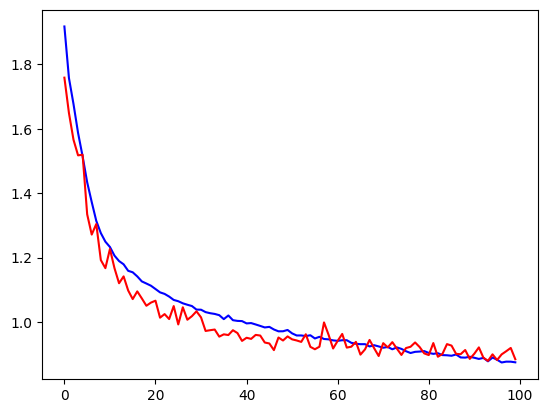

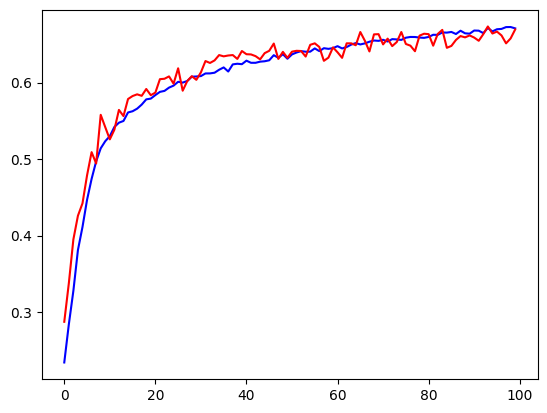

In [19]:
'''
loss:訓練集損失值
accuracy:訓練集準確率
val_loss:測試集損失率
val_accurzcy:測試集準確率

兩個loss都在持續下降，代表網絡仍再學習
train的loss下降，而val_loss不變，過擬合，max pool或者正規化
train的loss不變，而val_loss下降，資料集有問題，檢查資料集
train的loss不變，而val_loss不變，說明在學習的過程遭遇了瓶頸，需要減小學習率或批量的數目
train的loss上升，而val_loss上升，說明神經網絡的設計不當，訓練的超參數不當，這是最差的情況

可以加入終止的程序
'''
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.show()
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.show()

### 繪製訓練和驗證指標的分布情形

In [109]:
df_accu = pd.DataFrame(
    {'train':history.history['accuracy'],
    'valid':history.history['val_accuracy']}
)

df_loss = pd.DataFrame(
    {'train':history.history['loss'],
    'valid':history.history['val_loss']}
)

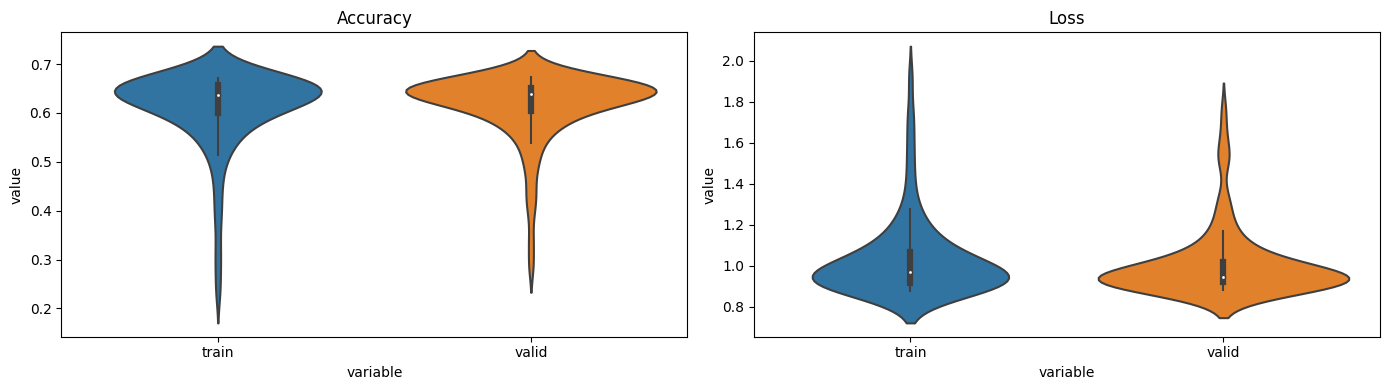

In [116]:
fig = plt.figure(0, (14,4))

# 第一張圖
ax = plt.subplot(1,2,1)
sns.violinplot(data = pd.melt(df_accu), x = 'variable', y = 'value', showfliers = False)
plt.title('Accuracy')
plt.tight_layout()

# 第二張圖，損失函數，愈小愈好
ax = plt.subplot(1,2,2)
sns.violinplot(data = pd.melt(df_loss), x = 'variable', y = 'value', showfliers = False)
plt.title('Loss')
plt.tight_layout()

# 儲存
plt.savefig('performance_dist.png')

plt.show()

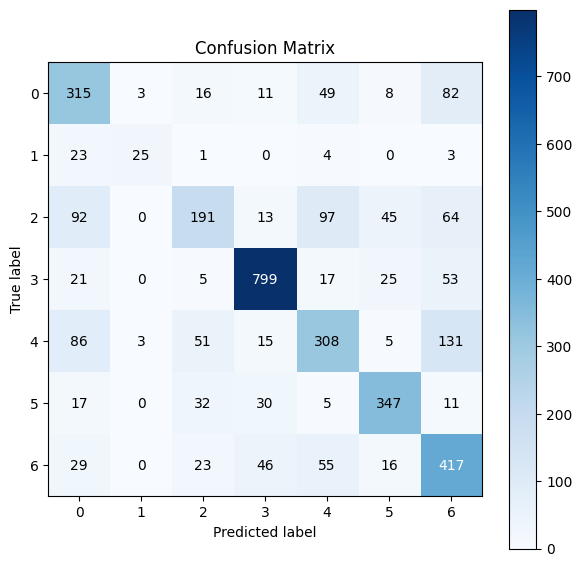

In [134]:
# 繪製cofusion matrix
'''
predice與predict_classes的差別
X_valid = x_test

{0: ' 生氣', 1: '厭惡', 2: '害怕', 3: '快樂', 4: '難過', 5: '驚訝', 6: '中性'}

'''
# 求類別ID，兩種寫法

yhat_valid = cnn_model.predict(x_test).argmax(axis = 1)
# yhat_valid = len(np.argmax(cnn_model.predict(x_test),axis=-1))

# scikitplot
scikitplot.metrics.plot_confusion_matrix(
    np.argmax(y_test, axis=1),
    yhat_valid,
    figsize=(7,7)
)

plt.show()

# 存檔


# yhat_valid = model.predict_classes(X_valid)
# scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
# pyplot.savefig("confusion_matrix_dcnn.png")
'''
{0: ' 生氣', 1: '厭惡', 2: '害怕', 3: '快樂', 4: '難過', 5: '驚訝', 6: '中性'}
'''

In [130]:
np.argmax(cnn_model.predict(x_test),axis=-1)

array([3, 4, 2, ..., 3, 6, 2], dtype=int64)

In [138]:
'''
{0: ' 生氣', 1: '厭惡', 2: '害怕', 3: '快樂', 4: '難過', 5: '驚訝', 6: '中性'}
https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html
'''

print(classification_report(np.argmax(y_test,axis=1), yhat_valid))

              precision    recall  f1-score   support

           0       0.54      0.65      0.59       484
           1       0.81      0.45      0.57        56
           2       0.60      0.38      0.47       502
           3       0.87      0.87      0.87       920
           4       0.58      0.51      0.54       599
           5       0.78      0.79      0.78       442
           6       0.55      0.71      0.62       586

    accuracy                           0.67      3589
   macro avg       0.67      0.62      0.64      3589
weighted avg       0.67      0.67      0.67      3589



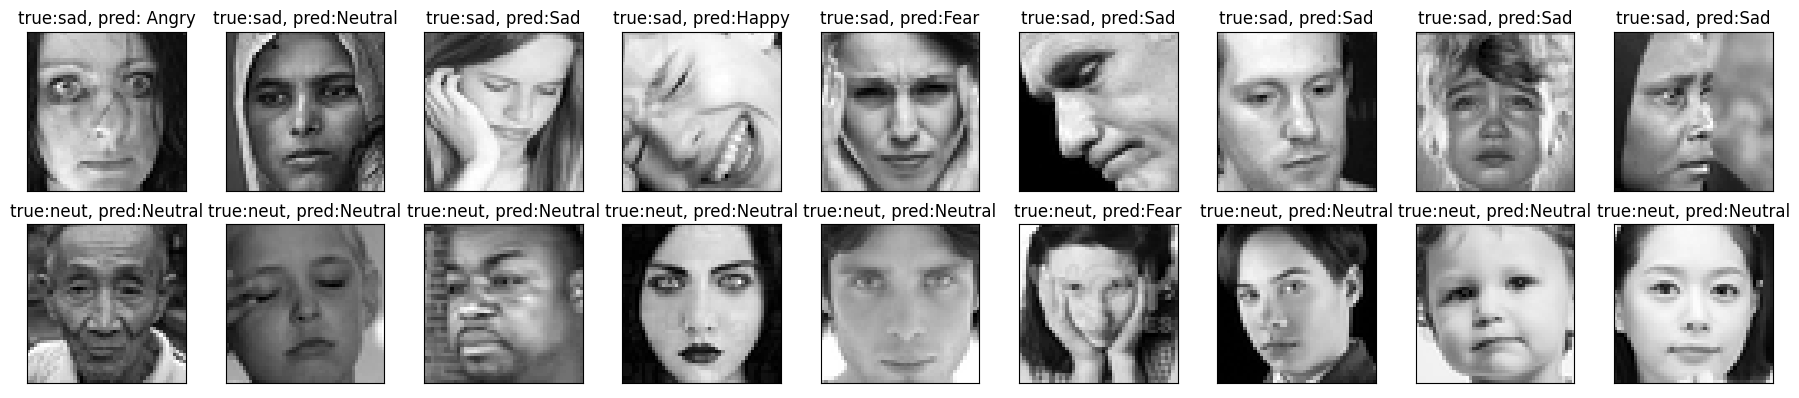

In [217]:
# 檢查
# 後續

emotion_map = {0: ' Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# 設定隨機數，有設定的好處是每次的隨機數都會固定
np.random.seed(2)

# np.random.choice隨機再序列中抽取數值
# np.where，滿足條件(condition)，輸出x，不滿足輸出y，返回的是索引
# 七行中(七個情緒)，取第四行，為悲傷的情緒，並指挑九個

random_sad_imgs = np.random.choice(np.where(y_test[:,4]==1)[0], size =9)
random_nutral_imgs = np.random.choice(np.where(y_test[:,6]==1)[0], size = 9)

fig = plt.figure(1,(18,4))

# enumerate，將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標
for i,(sadidx, neuidex) in enumerate(zip(random_sad_imgs, random_nutral_imgs)):
#     print(i)
#     print(sadidx)
    ax = plt.subplot(2,9, i+1)
    sample_img = x_test[sadidx,:,:,0]
    #讀取檔案
    ax.imshow(sample_img, cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"true:sad, pred:{emotion_map[cnn_model.predict(sample_img.reshape(1,48,48,1))[0].argmax(axis = 0)]}")
    
    ax = plt.subplot(2,9, i+10)
    sample_img = x_test[neuidex,:,:,0]
    ax.imshow(sample_img, cmap= 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"true:neut, pred:{emotion_map[cnn_model.predict(sample_img.reshape(1,48,48,1))[0].argmax(axis = 0)]}")
    
    
plt.tight_layout()    
plt.show()
#     print(sample_img)

# 我們模型的一些錯誤是由於數據本身的錯誤造成的。

In [191]:
sample_img.shape

(48, 48)

In [196]:
type(sample_img.reshape(1,48,48,1))

numpy.ndarray

In [187]:
x_test[1].shape

(48, 48, 1)

In [184]:
x_test[:,:].shape

(3589, 48, 48, 1)

In [150]:
y_test.shape

(3589, 7)

In [151]:
y_test[:,1].shape

(3589,)

In [173]:
type(x_test)

numpy.ndarray